In [1]:
import os, importlib, sys, time

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
import scipy.linalg as la
import scipy.stats as stats
import scipy.optimize as opt

In [4]:
from tqdm import tqdm

In [5]:
import freqepid

# 1. parameters

In [6]:
T = 120
T0 = 40

In [7]:
GPi = np.load('data/GPi.npz')

## observation parameters

In [8]:
pi = np.zeros(T+T0)
# pi[:min(GPi['pi'].shape[0], T+T0)] = GPi['pi'][:min(GPi['pi'].shape[0], T+T0)]
pi[0] = 1

$$Y_t = NegBinom( \frac{EY_t}{r_Y + EY_t}, r_Y )$$

$$ EY_t = \alpha\sum_{s=1}^{t-1} I_s \pi_{t-s} $$

## latent parameters

In [9]:
g = np.zeros(T+T0)
g[:min(GPi['g'].shape[0], T+T0)] = GPi['g'][:min(GPi['g'].shape[0], T+T0)]

In [21]:
d = 2
betas = np.array([
    np.linspace(-np.log(5.5)-0.5, -np.log(5.5)+0.5, 21),     
    np.linspace(0, -1, 21),
]).T

In [22]:
r_I = 10
K = 6.5
sigma_x = 0.3

$$I_t = NegBinom( \frac{EI_t}{r_I + EI_t}, r_I )$$

$$ EI_t = R(\bar{A}_t, \beta) \sum_{s=1}^{t-1} I_s g_{t-s} $$

$$R(\bar{A}_t, \beta) = \frac{K}{1+\exp(- \beta^\top A_t)}$$

## seed values

In [23]:
mu = np.log(100)

$$I_{[-T_0,0)} = \exp(\mu_0)$$

## simulation setting

In [24]:
num_beta = 21
num_sim = 100

# 2. Fit

In [25]:
from sklearn.linear_model import LinearRegression, LogisticRegression

In [26]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [27]:
lamda = 0.1
num_iter = 100

In [28]:
model = freqepid.Model(GPi['g'], [1], 1, K, T0, "nbinom")

In [29]:
Pi = np.concatenate([[0],pi])[np.maximum(0, np.arange(T)[:,None] - np.arange(T))]
Pi0 = np.concatenate([[0],pi])[np.maximum(0, np.arange(T)[:,None] - np.arange(-T0,0))]

In [30]:
G = np.concatenate([[0],g])[np.maximum(0, np.arange(T)[:,None] - np.arange(T))]
G0 = np.concatenate([[0],g])[np.maximum(0, np.arange(T)[:,None] - np.arange(-T0,0))]

In [31]:
bsim = np.zeros((num_beta,num_sim,d))

In [32]:
for iter_beta in tqdm(np.arange(num_beta), desc='beta', leave=None, position=0):
    data = pd.read_feather('data/simulation_phantom_%.2d.feather'%iter_beta)
    
    for iter_sim in tqdm(np.arange(num_sim), desc='SIM', leave=None, position=0):
        # start_sim = time.time()
        
        data_i = data[data['sim']==iter_sim]

        # estimation of pi
        X_pi = np.stack([data_i.iloc[1:,3], data_i.iloc[:-1,5], data_i.iloc[:-1,8]], -1)
        Y_pi = np.array(data_i.iloc[1:,5])
        pi_fit = LogisticRegression(penalty=None).fit(X_pi, Y_pi)
        ghat = np.concatenate([pi_fit.intercept_, pi_fit.coef_[0]])

        X_varpi = data_i.iloc[:-1,5:6]
        varpi_fit = LogisticRegression(penalty=None).fit(X_varpi, Y_pi)

        # estimation of px
#         X_px = np.stack([data_i.iloc[:-1,3], data_i.iloc[:-1,5], 
#                          # data_i.iloc[:-1,8]
#                         ], -1)
#         Y_px = np.array(data_i.iloc[1:,3])
#         px_fit = LinearRegression().fit(X_px, Y_px)
#         ahat = np.concatenate([[px_fit.intercept_], px_fit.coef_, [0]])
#         shat_x = np.sqrt(np.mean((Y_px - px_fit.predict(X_px))**2))

        # estimation of mu
        ## initialization
        X_mu = np.stack([
            np.full(T, 1),
            data_i["intervention"].to_numpy()
        ], -1)
        Y_mu = data_i["death"].to_numpy()
        
        nmle, mmle, bmle, ll =\
        model.fit(X_mu, Y_mu, n_iter=100, step_size=1,
                  history=False, verbose=False)

        bhat = bmle
        I0 = np.full(T0, np.exp(mmle))
        A = data_i["intervention"].to_numpy()
        I = data_i["infection"].to_numpy()

        ws = varpi_fit.predict_proba(X_varpi)[np.arange(T-1),Y_pi.astype(int)] \
             / pi_fit.predict_proba(X_pi)[np.arange(T-1),Y_pi.astype(int)]
        Ws = np.cumprod(np.concatenate([[1], ws], -1), -1)
        hs = np.stack([
            np.full(T, 1),
            A - np.concatenate([[0], varpi_fit.predict_proba(X_varpi)[np.arange(T-1),Y_pi.astype(int)]]),
        ])

        for i in np.arange(num_iter):
            XAs_MC = X_mu
    
            R_MC = K / (1 + np.exp(- XAs_MC @ bhat))
            dRdb_MC = (R_MC * (1 - R_MC/K))[...,None] * XAs_MC

            L_MC = R_MC[:,None] * G
            L0_MC = R_MC[:,None] * G0

            dLdb_MC = dRdb_MC[...,None,:] * G[...,None]
            dL0db_MC = dRdb_MC[...,None,:] * G0[...,None]

            inv_ImL = la.inv(np.eye(T)-L_MC) 

            EI_MC = inv_ImL @ (L0_MC @ I0)
            dEIdb_MC = inv_ImL @ (
                np.sum(dLdb_MC * EI_MC[:,None], -2)
                + np.sum(dL0db_MC * I0[:,None], -2)
            )

            phi = EI_MC
            dphidb = dEIdb_MC
        
            EE = np.sum((I - phi) * hs * Ws, -1)
            dEEdb = np.sum(- dphidb * (hs * Ws)[...,None], -2)
            db = np.linalg.lstsq(dEEdb, EE)[0]
            db = db / np.maximum(1, np.sqrt(np.sum(db**2)))
            bhat = bhat - lamda * db

        bsim[iter_beta, iter_sim] = bhat
        
        # sys.__stdout__.write("%d-%d-th simulation finished, %f sec.\n"
        #                      %(iter_beta+1, iter_sim+1, time.time()-start_sim))
        # sys.__stdout__.flush()

beta:   0%|          | 0/21 [00:00<?, ?it/s]

SIM:   0%|          | 0/100 [00:00<?, ?it/s]

SIM:   0%|          | 0/100 [00:00<?, ?it/s]

SIM:   0%|          | 0/100 [00:00<?, ?it/s]

SIM:   0%|          | 0/100 [00:00<?, ?it/s]

SIM:   0%|          | 0/100 [00:00<?, ?it/s]

SIM:   0%|          | 0/100 [00:00<?, ?it/s]

SIM:   0%|          | 0/100 [00:00<?, ?it/s]

SIM:   0%|          | 0/100 [00:00<?, ?it/s]

SIM:   0%|          | 0/100 [00:00<?, ?it/s]

SIM:   0%|          | 0/100 [00:00<?, ?it/s]

SIM:   0%|          | 0/100 [00:00<?, ?it/s]

SIM:   0%|          | 0/100 [00:00<?, ?it/s]

SIM:   0%|          | 0/100 [00:00<?, ?it/s]

SIM:   0%|          | 0/100 [00:00<?, ?it/s]

SIM:   0%|          | 0/100 [00:00<?, ?it/s]

SIM:   0%|          | 0/100 [00:00<?, ?it/s]

SIM:   0%|          | 0/100 [00:00<?, ?it/s]

SIM:   0%|          | 0/100 [00:00<?, ?it/s]

SIM:   0%|          | 0/100 [00:00<?, ?it/s]

SIM:   0%|          | 0/100 [00:00<?, ?it/s]

SIM:   0%|          | 0/100 [00:00<?, ?it/s]

In [33]:
np.savez('result_phantom_EE.npz', bsim = bsim)

# 3. Result

In [35]:
result = np.load('result_phantom_EE.npz')
bsim = result['bsim']

In [36]:
from matplotlib import ticker

In [37]:
betas[:,-1]

array([ 0.  , -0.05, -0.1 , -0.15, -0.2 , -0.25, -0.3 , -0.35, -0.4 ,
       -0.45, -0.5 , -0.55, -0.6 , -0.65, -0.7 , -0.75, -0.8 , -0.85,
       -0.9 , -0.95, -1.  ])

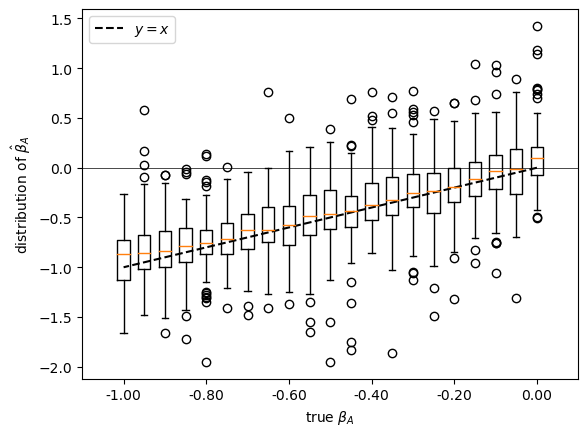

In [38]:
plt.boxplot(bsim[:,:,-1].T, positions=betas[:,-1], widths=0.03)
plt.plot(betas[:,-1], betas[:,-1], linestyle='--', color='black', label=r'$y=x$')
plt.axhline(y=0, linewidth=0.5, color='black')
plt.xlim(np.min(betas[:,-1])-0.1, np.max(betas[:,-1])+0.1)
plt.xticks(np.linspace(np.min(betas[:,-1]), np.max(betas[:,-1]), 6), 
           np.linspace(np.min(betas[:,-1]), np.max(betas[:,-1]), 6))
plt.gca().xaxis.set_major_formatter(ticker.StrMethodFormatter("{x:.2f}"))
plt.ylabel(r'distribution of $\hat\beta_A$'); plt.xlabel(r'true $\beta_A$'); plt.legend()
plt.show()

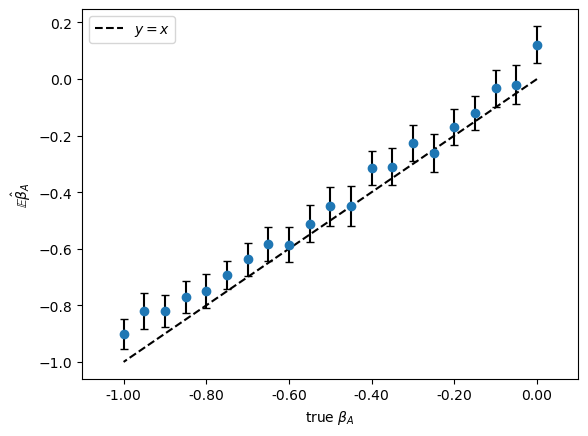

In [40]:
plt.errorbar(betas[:,-1], np.mean(bsim[:,:,-1], -1), yerr=2*np.std(bsim[:,:,-1],-1)/10, 
             ecolor='black', capsize=3, fmt="o")
plt.plot(betas[:,-1], betas[:,-1], linestyle='--', color='black', label=r'$y=x$')
plt.xlim(np.min(betas[:,-1])-0.1, np.max(betas[:,-1])+0.1)
plt.xticks(np.linspace(np.min(betas[:,-1]), np.max(betas[:,-1]), 6), 
           np.linspace(np.min(betas[:,-1]), np.max(betas[:,-1]), 6))
plt.gca().xaxis.set_major_formatter(ticker.StrMethodFormatter("{x:.2f}"))
plt.xlabel(r'true $\beta_A$'); plt.ylabel(r'$\mathbb{E}\hat\beta_A$'); plt.legend()
plt.show()